In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from torchvision import transforms, models, datasets
import torchvision
import matplotlib.pyplot as plt
import os
from skimage.color import rgb2gray
from skimage.color import gray2rgb
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


from utils import *
from model import ColorizationNet
from data_loader import *
from accuracy import *

# Utils

In [40]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# Benchmark

In [58]:
checkpoints_path = 'best_models'
class_reb_path = os.path.join(checkpoints_path, 'celeba_reb-71.pth')

In [67]:
all_imgs_path = 'data/test/human'
imgs = os.listdir(all_imgs_path)
imgs = [os.path.join(all_imgs_path, path) for path in imgs]
imgs.sort()

model = ColorizationNet(loss_type='classification')
checkpoint = torch.load(class_reb_path, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['model_state_dict'])

# batch_gray, batch_ab, batch_smooth  = next(iter(dataloader))
images_benchmark = []

for i, img_path in enumerate(imgs):
    if i == 144:
        break
    prediction = get_img_prediction(model, img_path)
    images_benchmark.append(prediction)

transformations = transforms.Compose([transforms.ToTensor(), transforms.Resize((h, w))])
images_benchmark = [transformations(img) for img in images_benchmark]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


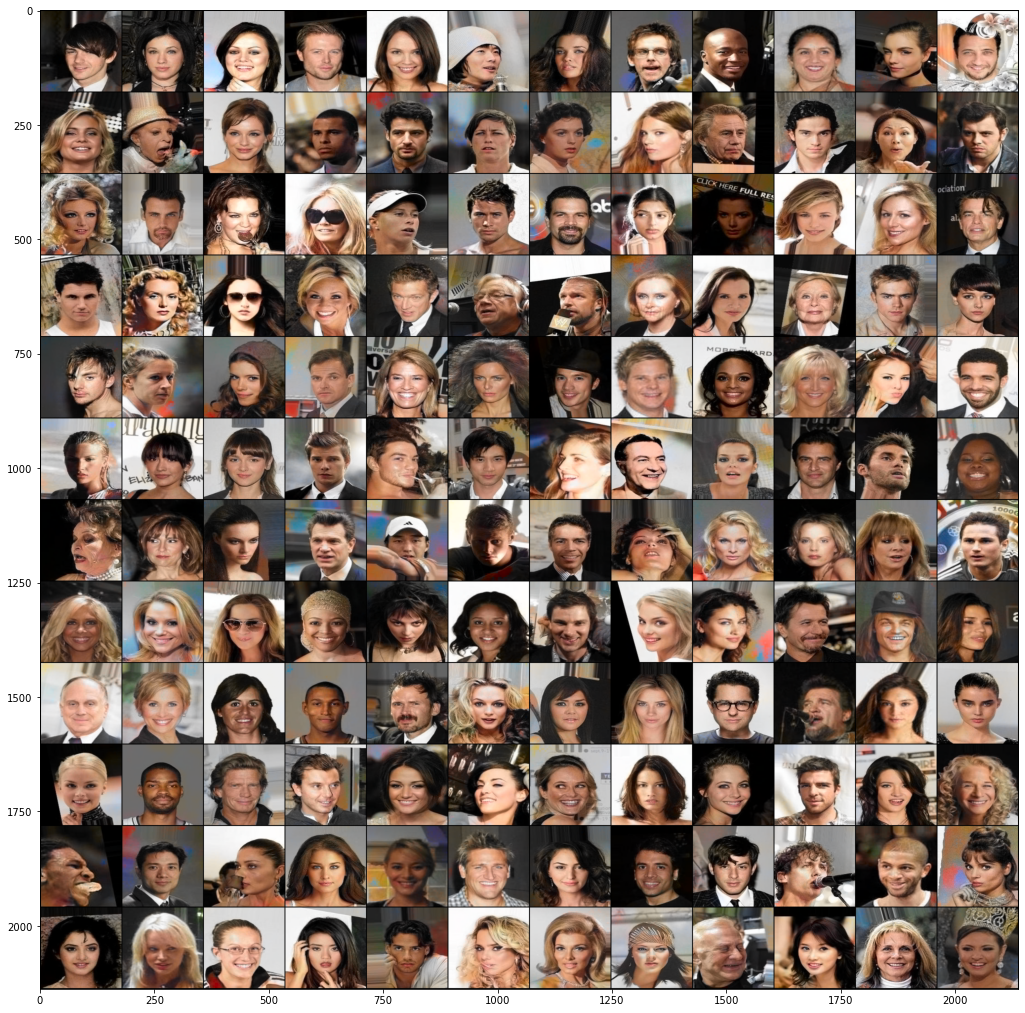

In [68]:
grid_img = torchvision.utils.make_grid(images_benchmark, nrow=12)
plt.figure(figsize=(20, 18))
show(grid_img)
torchvision.utils.save_image(grid_img, 'gh_images/test_benchmark.jpg')

# Bias images

In [70]:
bad_imgs = 'data/working_bad/'
imgs = os.listdir(bad_imgs)
imgs = [os.path.join(bad_imgs, path) for path in imgs]
imgs.sort()

# batch_gray, batch_ab, batch_smooth  = next(iter(dataloader))
images_gt = []
images_bad = []

for i, img_path in enumerate(imgs):
    img_rgb = load_img_np(img_path)
    images_gt.append(img_rgb)
    prediction = get_img_prediction(model, img_path)
    images_bad.append(prediction)

images_bad = images_gt + images_bad    

transformations = transforms.Compose([transforms.ToTensor(), transforms.Resize((h, w))])
images_bad = [transformations(img) for img in images_bad]

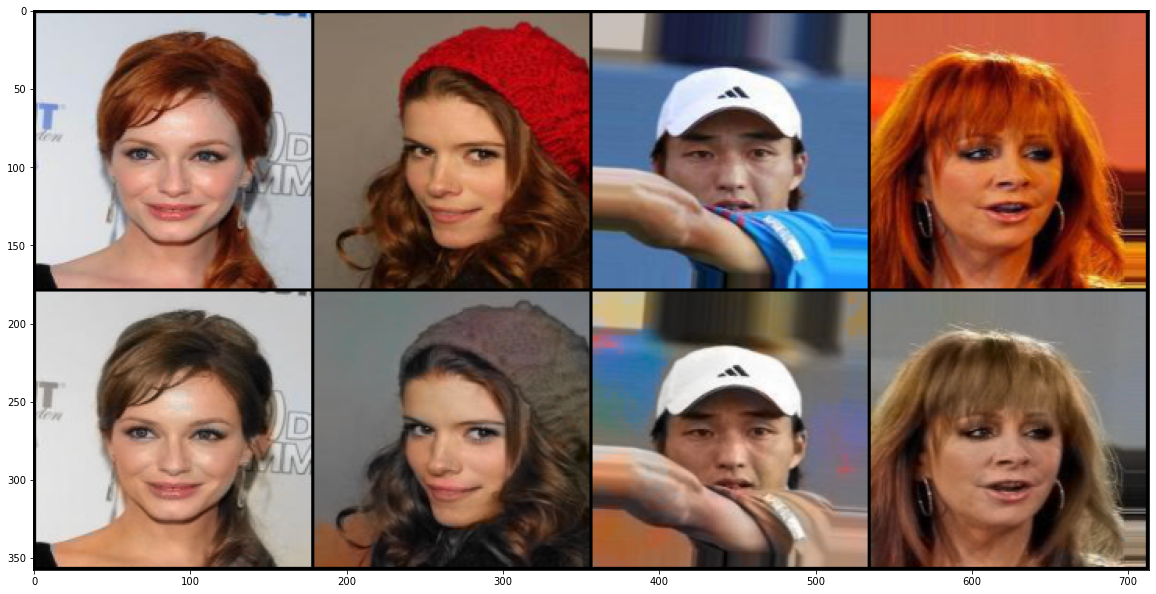

In [73]:
grid_img = torchvision.utils.make_grid(images_bad, nrow=4)
plt.figure(figsize=(20, 18))
show(grid_img)
torchvision.utils.save_image(grid_img, 'gh_images/bias_images.jpg')

# Temperature comparison

In [51]:
img_path = 'data/working_good/'
temperatures = [1, .77, .58, .38, .29, .14, 0.4]
model = ColorizationNet(loss_type='classification')
checkpoint = torch.load(class_reb_path, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['model_state_dict'])

transformations = transforms.Compose([transforms.Resize((h, w))])
dataset = GrayscaleImageFolder(img_path, transform=transformations)
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=1,
                                         shuffle=False)

batch_gray, batch_ab, batch_smooth  = next(iter(dataloader))
images_temp = []

batch_output = model(batch_gray)

for img_gray, output_smooth, img_ab in zip(batch_gray, batch_output, batch_ab):
    img_rgb = gray_ab_tensor2rgb(img_gray, img_ab)
    images_temp.append(transforms.ToTensor()(img_rgb))
    for temp in temperatures:
        prediction_rgb = gray_smooth_tensor2rgb(img_gray, output_smooth, temperature=temp)
        images_temp.append(transforms.ToTensor()(prediction_rgb))

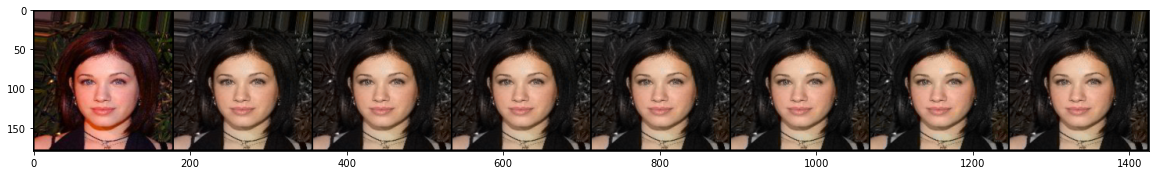

In [55]:
grid_img = torchvision.utils.make_grid(images_temp, nrow=8)
plt.figure(figsize=(20, 18))
show(grid_img)
torchvision.utils.save_image(grid_img, 'gh_images/temp_comparison.jpg')

# Compare models

## Prepare images and models paths

In [43]:
good_results_imgs = 'data/working_good/human'
imgs = os.listdir(good_results_imgs)
imgs = [os.path.join(good_results_imgs, path) for path in imgs]

checkpoints_path = 'best_models'
reg_path = os.path.join(checkpoints_path, 'celeba_reg-81.pth')
class_reb_path = os.path.join(checkpoints_path, 'celeba_reb-71.pth')
class_noreb_path = os.path.join(checkpoints_path, 'celeba_noreb-80.pth')

model_types = [(reg_path, REGRESSION), (class_reb_path, CLASSIFICATION), (class_noreb_path, CLASSIFICATION)]

## Apply models on images

In [44]:
images = []

for img_path in imgs:
    img_rgb = load_img_np(img_path)
    img_gray = rgb2gray(img_rgb)
    img_gray = gray2rgb(img_gray)
    images.append(img_gray)
    for checkpoint_path, loss_type in model_types:
        model = ColorizationNet(loss_type=loss_type)
        checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
        model.load_state_dict(checkpoint['model_state_dict'])
        prediction = get_img_prediction(model, img_path)
        images.append(prediction)
    images.append(img_rgb)
    
transformations = transforms.Compose([transforms.ToTensor(), transforms.Resize((h, w))])
images = [transformations(img) for img in images]

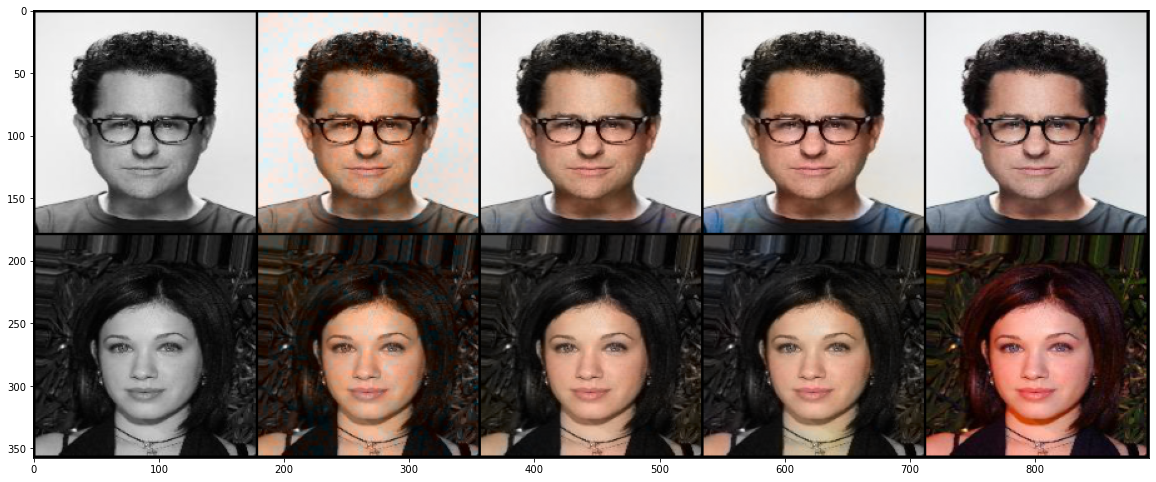

In [45]:
grid_img = torchvision.utils.make_grid(images, nrow=5)
torchvision.utils.save_image(grid_img, 'gh_images/models.jpg')
plt.figure(figsize=(20, 18))
show(grid_img)

# Classificator (on fruits)

In [4]:
data_dir = os.path.join('fruit_data', 'val')

In [5]:
def vgg_accuracy(vgg_model, data_dir, transformations):
    
    fruit_test = datasets.ImageFolder(os.path.join('fruit_data', 'val'), transform=transformations)
    fruit_loader = torch.utils.data.DataLoader(fruit_test, batch_size=8, shuffle=False)
    
    vgg_model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(fruit_loader):
        outputs = vgg_model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        accuracy = running_corrects.double() / len(fruit_loader.dataset)
        
    return accuracy

## Instantiate VGG model

In [6]:
num_classes = 13
criterion = nn.CrossEntropyLoss()

vgg_model = models.resnet18(pretrained=True)
for param in vgg_model.parameters():
    param.requires_grad = False
num_ftrs = vgg_model.fc.in_features
vgg_model.fc = nn.Linear(num_ftrs, num_classes)

vgg_model.load_state_dict(torch.load('best_models/vgg_model.pth'))

<All keys matched successfully>

## Accuracy on ground truth images

In [7]:
fruit_folder_path = 'fruit_data/test'

In [8]:
transformations = transforms.Compose([transforms.ToTensor(), transforms.Resize((h, w))])

vgg_accuracy(vgg_model, data_dir, transformations)

100%|██████████| 33/33 [00:13<00:00,  2.52it/s]


tensor(0.4402, dtype=torch.float64)

## Accuracy on black and white images

In [9]:
float_cast = lambda x: x.type(torch.float)
transformations = transforms.Compose([np.array, rgb2gray, gray2rgb, transforms.ToTensor(), float_cast, transforms.Resize((h, w))])

vgg_accuracy(vgg_model, data_dir, transformations)

100%|██████████| 33/33 [00:22<00:00,  1.49it/s]


tensor(0.3320, dtype=torch.float64)

## Accuracy on colorized images

### Load ColorNet model

In [10]:
checkpoint_path = 'best_models/fruit_reb-100.pth'
model = ColorizationNet(loss_type='classification')
checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['model_state_dict'])

def colorize(img):
    img_lab = rgb2lab(img)
    img_gray = img_lab[:, :, 0] / 100
    img_gray_small = resize(img_gray, (h, w))
    img_gray_tensor = torch.from_numpy(img_gray_small).unsqueeze(0).float()
    img_gray_batch = img_gray_tensor.unsqueeze(0)
    img_smooth = model(img_gray_batch)[0]
    if model.loss_type == 'classification':
        img_lab = gray_smooth_tensor2lab_npy(img_gray_tensor, img_smooth)
    else:
        img_lab = gray_ab_tensor2lab(img_gray_tensor, img_smooth)
    img_gray = img_gray * 100
    img_rgb = lab2rgb(img_lab)
    img_from_array = (img_rgb * 255).astype(np.uint8)

    return img_from_array

In [11]:
transformations = transforms.Compose([np.array, colorize, transforms.ToTensor(), transforms.Resize((h, w))])

vgg_accuracy(vgg_model, data_dir, transformations)

100%|██████████| 33/33 [03:17<00:00,  6.00s/it]


tensor(0.3668, dtype=torch.float64)

In [12]:
def random_color(x):
    x = resize(x, (h, w))
    x[..., 1:] =  get_random_ab_channel(image_list_from_dir('fruit_data/train'), do_resize=True)
    return x

In [13]:
transformations = transforms.Compose([np.array, rgb2lab, random_color, lab2rgb, transforms.ToTensor(), float_cast, transforms.Resize((h, w))])

vgg_accuracy(vgg_model, data_dir, transformations)

100%|██████████| 33/33 [06:01<00:00, 10.95s/it]


tensor(0.2780, dtype=torch.float64)